In [27]:
import cirq
import numpy as np
import collections

# Thinh P. Tran
# Wrong answer generated by Gemini 2.5 Pro
# wrong order of apply S gate

def qft_inverse(qubits):
    """Yields the operations for an inverse Quantum Fourier Transform."""
    n = len(qubits)
    if n == 0:
        return
    # Swap qubits
    for i in range(n // 2):
        yield cirq.SWAP(qubits[i], qubits[n - 1 - i])
    # Apply controlled rotations and Hadamards
    for i in range(n):
        for j in range(i):
            yield cirq.CZ(qubits[j], qubits[i])**-1
        yield cirq.H(qubits[i])

def run_phase_estimation(m):
    """Builds, prints, and runs the QPE algorithm for the S gate."""
    # 1. Initialize qubits
    counting_qubits = cirq.LineQubit.range(m)
    target_qubit = cirq.LineQubit(m)

    # 2. Build the circuit
    circuit = cirq.Circuit()
    circuit.append(cirq.X(target_qubit)) 
    circuit.append(cirq.H.on_each(*counting_qubits))

    # Apply controlled-S^(2^j) operations
    for j, qubit in enumerate(counting_qubits):
        s_power = cirq.S**(2**j)
        circuit.append(s_power.controlled()(qubit, target_qubit))

    # Apply inverse QFT on counting qubits
    circuit.append(qft_inverse(counting_qubits))

    # Add measurement
    circuit.append(cirq.measure(*counting_qubits, key='result'))

    # 3. Print the circuit diagram
    print(f"--- Circuit Diagram: m = {m} counting qubit(s) ---")
    print(circuit)
    print("-" * 50)


    # 4. Simulate and process results
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=100)
    # Get the dictionary of measurement counts
    counts = collections.Counter(results.measurements['result'][:, 0])
    most_common_measurement = counts.most_common(1)[0][0]
    phase_estimate = most_common_measurement / (2**m)
    
    return most_common_measurement, phase_estimate, counts

# --- Run for m = 1, 2, and 3 ---
print("Estimating the phase for the S gate where theta = 1/4 = 0.25\n")

for m_qubits in [1, 2, 3]:
    measurement, phase, counts_dict = run_phase_estimation(m_qubits)
    print(f"--- Simulation Results: m = {m_qubits} ---")
    # Display the full count dictionary
    print(f"  Measurement counts: {counts_dict}")
    print(f"  Most frequent measurement: {measurement} (binary: {measurement:0{m_qubits}b})")
    print(f"  Estimated phase (θ): {measurement}/(2^{m_qubits}) = {phase:.4f}\n")

Estimating the phase for the S gate where theta = 1/4 = 0.25

--- Circuit Diagram: m = 1 counting qubit(s) ---
0: ───H───@───────H───M('result')───
          │
1: ───X───@^0.5─────────────────────
--------------------------------------------------
--- Simulation Results: m = 1 ---
  Measurement counts: Counter({0: 52, 1: 48})
  Most frequent measurement: 0 (binary: 0)
  Estimated phase (θ): 0/(2^1) = 0.0000

--- Circuit Diagram: m = 2 counting qubit(s) ---
0: ───H───@───────────×───H───@───────M('result')───
          │           │       │       │
1: ───H───┼───────@───×───────@───H───M─────────────
          │       │
2: ───X───@^0.5───@─────────────────────────────────
--------------------------------------------------
--- Simulation Results: m = 2 ---
  Measurement counts: Counter({1: 100})
  Most frequent measurement: 1 (binary: 01)
  Estimated phase (θ): 1/(2^2) = 0.2500

--- Circuit Diagram: m = 3 counting qubit(s) ---
                                        ┌──┐
0: ───H───@─────

In [37]:
import cirq
import numpy as np

def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)


def phase_estimation_circuit(m, target_qubit, control_qubits):
    """Constructs a phase estimation circuit for the S gate with m counting qubits."""
    # Define the S gate
    S_gate = cirq.ZPowGate(exponent=0.5)  # S gate is Z^(1/2), applies phase e^(iπ/2)

    # Initialize circuit
    circuit = cirq.Circuit()

    # Prepare the target qubit in |1> state (eigenstate of S)
    circuit.append(cirq.X(target_qubit)) #-- Thinh P. Tran - Change to |1> since |1> is the eigen vector of S gate

    # Apply Hadamard to all counting qubits
    circuit.append(cirq.H(q) for q in control_qubits)

    # Apply controlled S^(2^k) gates
    for k in range(m):
        # S^(2^k) is ZPowGate with exponent 2^k * 0.5
        controlled_S = cirq.ControlledGate(S_gate ** (2 ** k))
        circuit.append(controlled_S(control_qubits[m - 1 - k], target_qubit))

    # Inverse QFT: Apply gates in reverse order of QFT
    circuit.append(make_qft_inverse(control_qubits))  

    # Measure counting qubits
    circuit.append(cirq.measure(*control_qubits, key='result'))

    return circuit

def run_phase_estimation(m):
    """Runs phase estimation for m counting qubits, displays circuit, and prints results."""
    # Define qubits
    control_qubits = [cirq.NamedQubit(f'c{i}') for i in range(m)]
    target_qubit = cirq.NamedQubit('t')

    # Create circuit
    circuit = phase_estimation_circuit(m, target_qubit, control_qubits)

    # Display circuit
    print(f"\nCircuit for m = {m} control qubits:")
    print(circuit)

    # Simulate circuit
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=1000)

    counts = collections.Counter(results.measurements['result'][:, 0])

    # Print results
    print(f"\nResults for m = {m} counting qubits:")

    most_common_measurement = counts.most_common(1)[0][0]
    phase_estimate = most_common_measurement / (2**m)
    print(f"  Measurement counts: {counts}")
    print(f"  Most frequent measurement: {most_common_measurement} (binary: {most_common_measurement:0{m_qubits}b})")
    print(f"  Estimated phase (θ): {most_common_measurement}/(2^{m}) = {phase_estimate:.4f}\n")

# Run phase estimation for m = 1, 2, 3
for m in [1, 2, 3, 4, 5]:
    run_phase_estimation(m)


Circuit for m = 1 control qubits:
c0: ───H───@───H───M('result')───
           │
t: ────X───S─────────────────────

Results for m = 1 counting qubits:
  Measurement counts: Counter({1: 507, 0: 493})
  Most frequent measurement: 1 (binary: 001)
  Estimated phase (θ): 1/(2^1) = 0.5000


Circuit for m = 2 control qubits:
               ┌──┐
c0: ───H────────@─────@────────H───M('result')───
                │     │            │
c1: ───H───@────┼H────@^-0.5───────M─────────────
           │    │
t: ────X───S────Z────────────────────────────────
               └──┘

Results for m = 2 counting qubits:
  Measurement counts: Counter({1: 758, 0: 242})
  Most frequent measurement: 1 (binary: 001)
  Estimated phase (θ): 1/(2^2) = 0.2500


Circuit for m = 3 control qubits:
               ┌──┐   ┌─────────┐   ┌────────┐
c0: ───H───────────────@─────────────@───────────@────────H───M('result')───
                       │             │           │            │
c1: ───H────────@──────┼──@──────────┼───

In [29]:
import cirq
import numpy as np

def inverse_qft_circuit(m):
    """Constructs an inverse QFT circuit for m qubits."""
    # Define qubits
    qubits = [cirq.NamedQubit(f'q{i}') for i in range(m)]
    
    # Initialize circuit
    circuit = cirq.Circuit()
    
    # Inverse QFT: Apply gates in reverse order of QFT
    for i in range(m):
        # Apply Hadamard to the current qubit
        circuit.append(cirq.H(qubits[m - 1 - i]))
        # Apply controlled phase rotations
        for j in range(i + 1, m):
            angle = -np.pi / (2 ** (j - i))
            circuit.append(cirq.CZPowGate(exponent=angle / np.pi)(
                qubits[m - 1 - j], qubits[m - 1 - i]))
    
    return circuit

def display_inverse_qft(m):
    """Displays the inverse QFT circuit for m qubits."""
    circuit = inverse_qft_circuit(m)
    print(f"\nInverse QFT circuit for m = {m} qubits:")
    print(circuit)

# Display inverse QFT circuits for m = 1, 2, 3
for m in [1, 2, 3]:
    display_inverse_qft(m)


Inverse QFT circuit for m = 1 qubits:
q0: ───H───

Inverse QFT circuit for m = 2 qubits:
q0: ───────@────────H───
           │
q1: ───H───@^-0.5───────

Inverse QFT circuit for m = 3 qubits:
                    ┌────────┐
q0: ─────────────────@───────────@────────H───
                     │           │
q1: ───────@─────────┼──────H────@^-0.5───────
           │         │
q2: ───H───@^-0.5────@^-0.25──────────────────
                    └────────┘


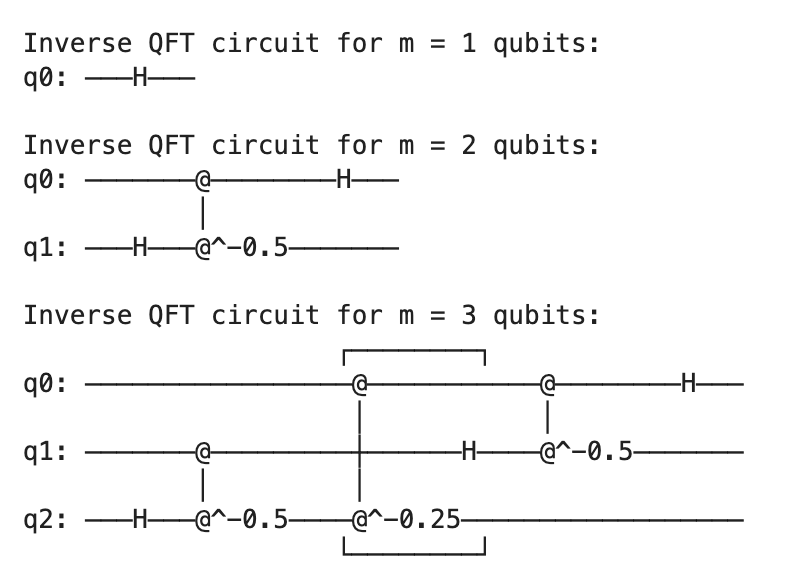

In [39]:
import cirq
import numpy as np

def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

def inverse_qft_circuit(m):
    """Constructs an inverse QFT circuit for m qubits."""
    # Define qubits
    qubits = [cirq.NamedQubit(f'q{i}') for i in range(m)]
    
    # Initialize circuit
    circuit = cirq.Circuit()
    
    # Inverse QFT: Apply gates in reverse order of QFT
    circuit.append(make_qft_inverse(qubits))  
    
    return circuit

def display_inverse_qft(m):
    """Displays the inverse QFT circuit for m qubits."""
    circuit = inverse_qft_circuit(m)
    print(f"\nInverse QFT circuit for m = {m} qubits:")
    print(circuit)

# Display inverse QFT circuits for m = 1, 2, 3
for m in [1, 2, 3]:
    display_inverse_qft(m)


Inverse QFT circuit for m = 1 qubits:
q0: ───H───

Inverse QFT circuit for m = 2 qubits:
q0: ───────@────────H───
           │
q1: ───H───@^-0.5───────

Inverse QFT circuit for m = 3 qubits:
                    ┌────────┐
q0: ─────────────────@───────────@────────H───
                     │           │
q1: ───────@─────────┼──────H────@^-0.5───────
           │         │
q2: ───H───@^-0.5────@^-0.25──────────────────
                    └────────┘
